In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc
import datetime
import matplotlib.pyplot as plt 
import matplotlib

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Bidirectional, Flatten, Dropout, BatchNormalization, Embedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.random import default_rng

In [4]:
import pickle
with open(r'additional_data\vocab_tokenized_reviews.pickle', 'rb') as tr_file, \
     open(r'additional_data\targets.npy', 'rb') as targets_file, \
     open(r'additional_data\max_len.pickle', 'rb') as ml_file, \
     open(r'additional_data\vocab.pickle', 'rb') as vocab_file:
    
    tokenized_reviews = np.array(pickle.load(tr_file), dtype = np.int32)
    targets = tf.one_hot(np.load(targets_file), 3, dtype = tf.int8).numpy()
    vocabulary = pickle.load(vocab_file)
    MAX_LEN = pickle.load(ml_file)

In [5]:
gc.collect()

11

In [6]:
X_train, X, y_train, y = train_test_split(tokenized_reviews, targets, test_size = 0.4, stratify = targets)
del tokenized_reviews, targets

X_test, X_val, y_test, y_val = train_test_split(X, y, test_size = 0.5, stratify = y)
del X, y

In [7]:
neg, neu, pos = (y_train[:, 0] == 1).sum(), (y_train[:, 1] == 1).sum(), (y_train[:, 2] == 1).sum()
_sum = neg + neu + pos
CLASS_WEIGHTS = {0: (1 / neg) * (_sum / 3),
                 1: (1 / neu) * (_sum / 3),
                 2: (1 / pos) * (_sum / 3)}
CLASS_WEIGHTS

{0: 2.2136572517372786, 1: 1.7766608195025415, 2: 0.5036755095665258}

In [8]:
class BalancedBatchGenerator:
    '''
    Генерирует сбалансированные мини-батчи поочерёдно выдавая  негативный, нейтральный и 
    положительные отзывы в случайном порядке до тех пор, пока отзывы одной из категорий не закончатся.
    Таким образом, если X - кол-во представителей самого малочисленного класса, то на каждой эпохе модели
    будет предоставляться по Х элементов каждого класса 
    
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rng = np.random.default_rng(42)
        
    def __iter__(self):
        inds = np.arange(len(self.X), dtype = 'int32')
        self.neg_inds = inds[self.y[:, 0] == 1]
        self.neu_inds = inds[self.y[:, 1] == 1]
        self.pos_inds = inds[self.y[:, 2] == 1]
        self.rng.shuffle(self.neg_inds)
        self.rng.shuffle(self.neu_inds)
        self.rng.shuffle(self.pos_inds)
        
        self.i = -1
        self.neg_i = -1
        self.neu_i = -1
        self.pos_i = -1
        self.iter_num = min(len(self.neg_inds), len(self.neu_inds), len(self.pos_inds))
        return self
    
    def __next__(self):
        self.i += 1
        if (self.neg_i >= self.iter_num - 1 or 
            self.neu_i >= self.iter_num - 1 or
            self.pos_i >= self.iter_num - 1):
            raise StopIteration
        if self.i % 3 == 0:
            self.neg_i += 1
            ind = self.neg_inds[self.neg_i]
            return (self.X[ind], self.y[ind])
        if self.i % 3 == 1:
            self.neu_i += 1 
            ind = self.neu_inds[self.neu_i]
            return (self.X[ind], self.y[ind])
        if self.i % 3 == 2:
            self.pos_i += 1
            ind = self.pos_inds[self.pos_i]
            return (self.X[ind], self.y[ind])


In [9]:
class BatchGenerator:
    '''
    Генерирует несбалансированные мини-батчи поочерёдно выдавая 
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rng = np.random.default_rng(42)
        
    def __iter__(self):
        self.inds = np.arange(len(self.X), dtype = 'int32')
        self.rng.shuffle(self.inds)
        
        self.i = -1
        return self
    
    def __next__(self):
        self.i += 1
        if self.i < len(self.y):
            ind = self.inds[self.i]
            return (self.X[ind], self.y[ind])
        raise StopIteration 

In [10]:
def one_hot_to_labels(arr):
    pos_to_label = {0: 'neg',
                    1: 'neu',
                    2: 'pos'}
    out = []
    for el in arr:
        out.append(pos_to_label[el.argmax()])
    return out

In [11]:
def get_datasets(train, test, val, generators, out_sign, batch_size):
    tf_train = tf.data.Dataset.from_generator(generators[0], args = train,
                                              output_signature = out_sign)
    tf_test = tf.data.Dataset.from_generator(generators[1], args = test,
                                             output_signature = out_sign)
    tf_val = tf.data.Dataset.from_generator(generators[2], args = val,
                                            output_signature = out_sign)
    
    return tf_train.batch(batch_size), tf_test.batch(batch_size), tf_val.batch(batch_size)

In [12]:
gc.collect()

0

In [13]:
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

CALLBACKS = [val_loss_callback]

In [14]:
METRICS = ['accuracy', 
           tf.keras.metrics.Recall(class_id = 0, name = 'r_neg'),
           tf.keras.metrics.Recall(class_id = 1, name = 'r_neu'),
           tf.keras.metrics.Recall(class_id = 2, name = 'r_pos'),
           tf.keras.metrics.Precision(class_id = 0, name = 'p_neg'),
           tf.keras.metrics.Precision(class_id = 1, name = 'p_neu'),
           tf.keras.metrics.Precision(class_id = 2, name = 'p_pos')]

И немного кода, который (по итогам обучения) нарисует нам графики всех вышеуказанных характеристик 

In [15]:
# Эти параметры должны быть такими, чтоб графики выглядили более сносно.
# Размер шрифта цифр у осей
matplotlib.rcParams.update({'font.size': 50})
# Ширина линий, что составляют графики
matplotlib.rcParams.update({'lines.linewidth': 10})

def plot_train_info(history, num_epochs):
    epochs = [i for i in range(1, num_epochs + 1)]
    fig , ax = plt.subplots(3, 2)
    
    train_acc = history['accuracy']
    train_loss = history['loss']
    
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']
    
    train_r_neg = history['r_neg']
    train_r_neu = history['r_neu']
    train_r_pos = history['r_pos']
    
    train_p_neg = history['p_neg']
    train_p_neu = history['p_neu']
    train_p_pos = history['p_pos']

    val_r_neg = history['val_r_neg']
    val_r_neu = history['val_r_neu']
    val_r_pos = history['val_r_pos']
    
    val_p_neg = history['val_p_neg']
    val_p_neu = history['val_p_neu']
    val_p_pos = history['val_p_pos']
    
    fig.set_size_inches(100, 100)
    
    ax[0, 0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0, 0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0, 0].set_title('Training & Validation Accuracy')
    ax[0, 0].legend()
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('Accuracy')

    ax[0, 1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[0, 1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[0, 1].set_title('Testing Accuracy & Loss')
    ax[0, 1].legend()
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('Training & Validation Loss')
    
    ax[1, 0].plot(epochs, train_r_neg , 'g-o' , label = 'Training neg recall')
    ax[1, 0].plot(epochs, train_r_neu , 'r-o' , label = 'Training neu recall')
    ax[1, 0].plot(epochs, train_r_pos, 'b-o' , label = 'Training pos recall')
    ax[1, 0].set_title('Training recalls')
    ax[1, 0].legend()
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('Recall')
    
    ax[1, 1].plot(epochs, train_p_neg , 'g-o' , label = 'Training neg precision')
    ax[1, 1].plot(epochs, train_p_neu , 'r-o' , label = 'Training neu precision')
    ax[1, 1].plot(epochs, train_p_pos, 'b-o' , label = 'Training pos precision')
    ax[1, 1].set_title('Training precisions')
    ax[1, 1].legend()
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Presicion')
    
    ax[2, 0].plot(epochs, val_r_neg , 'g-o' , label = 'Validations neg recall')
    ax[2, 0].plot(epochs, val_r_neu , 'r-o' , label = 'Validations neu recall')
    ax[2, 0].plot(epochs, val_r_pos, 'b-o' , label = 'Validations pos recall')
    ax[2, 0].set_title('Validation recalls')
    ax[2, 0].legend()
    ax[2, 0].set_xlabel('Epochs')
    ax[2, 0].set_ylabel('Recall')
    
    ax[2, 1].plot(epochs, val_p_neg , 'g-o' , label = 'Validations neg precision')
    ax[2, 1].plot(epochs, val_p_neu , 'r-o' , label = 'Validations neu precision')
    ax[2, 1].plot(epochs, val_p_pos, 'b-o' , label = 'Validations pos precision')
    ax[2, 1].set_title('Validation precisions')
    ax[2, 1].legend()
    ax[2, 1].set_xlabel('Epochs')
    ax[2, 1].set_ylabel('Presicion')
    
    plt.show()

# Попытка номер раз

In [14]:
BATCH_SIZE = 256

output_signature = (tf.TensorSpec(shape = (MAX_LEN), dtype = tf.float64),
                    tf.TensorSpec(shape = (3), dtype = tf.int8))

tf_train, tf_test, tf_val = get_datasets((X_train, y_train), (X_test, y_test), (X_val, y_val),
                                          generators = [BatchGenerator, BatchGenerator, BatchGenerator],
                                          out_sign = output_signature, batch_size = BATCH_SIZE)

In [14]:
model = Sequential([Embedding(input_dim = (len(vocabulary)), output_dim = (25), mask_zero = True),
                    LSTM(150, activation = 'tanh', name = 'lstm_1', 
                         return_sequences = False, dropout = 0.8),
                    BatchNormalization(),
                    Dense(75, name = 'dense_1', activation = 'relu'),
                    BatchNormalization(),
                    Dropout(0.8),
                    Dense(3, name = 'dense_out', activation = 'softmax')], name = 'WithEmbeddings')

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy',
              metrics = METRICS)
model.summary()

Model: "WithEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 25)          5069800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               105600    
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 75)                11325     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)                300       
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense_out (Dense)            (None, 3)              

In [16]:
# После 10-ой эпохи экспоненциально уменьшать learning rate
def scheduler(epoch, lr):
    if epoch <= 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

# Его величество tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\with_bigger_dropout\1st_ep{epoch:02d}_v_l_{val_loss:.2f}.hdf5',
                            save_best_only = False)

history = model.fit(tf_train.repeat(), steps_per_epoch = len(y_train) // BATCH_SIZE,
                    validation_data = tf_val.repeat(), validation_steps = len(y_val) // BATCH_SIZE,
                    epochs = 25,
                    callbacks = CALLBACKS + [tensorboard_callback, model_checkpoint_callback, lr_callback],
                    class_weight = CLASS_WEIGHTS)

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
308/308 [==============================] - 567s 2s/step - loss: 1.6049 - accuracy: 0.3409 - r_neg: 0.2329 - r_neu: 0.2081 - r_pos: 0.2256 - p_neg: 0.1563 - p_neu: 0.1899 - p_pos: 0.6728 - val_loss: 1.1044 - val_accuracy: 0.1503 - val_r_neg: 0.0000e+00 - val_r_neu: 0.0000e+00 - val_r_pos: 0.0000e+00 - val_p_neg: 0.0000e+00 - val_p_neu: 0.0000e+00 - val_p_pos: 0.0000e+00
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
308/308 [==============================] - 559s 2s/step - loss: 1.0878 - accuracy: 0.4104 - r_neg: 0.0482 - r_neu: 0.0066 - r_pos: 0.0804 - p_neg: 0.2572 - p_neu: 0.1988 - p_pos: 0.8034 - val_loss: 1.0772 - val_accuracy: 0.4211 - val_r_neg: 0.0000e+00 - val_r_neu: 0.0000e+00 - val_r_pos: 1.1567e-04 - val_p_neg: 0.0000e+00 - val_p_neu: 0.0000e+00 - val_p_pos: 0.6667
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate t

In [17]:
test_pred = model.predict(X_test)

print(classification_report(one_hot_to_labels(test_pred), one_hot_to_labels(y_test)))

              precision    recall  f1-score   support

         neg       0.64      0.67      0.66      3831
         neu       0.58      0.29      0.39      9701
         pos       0.66      0.90      0.76     12802

    accuracy                           0.64     26334
   macro avg       0.63      0.62      0.60     26334
weighted avg       0.63      0.64      0.61     26334



Довольно не густо. Радует только то, что сеть находит 90% положительных отзывов

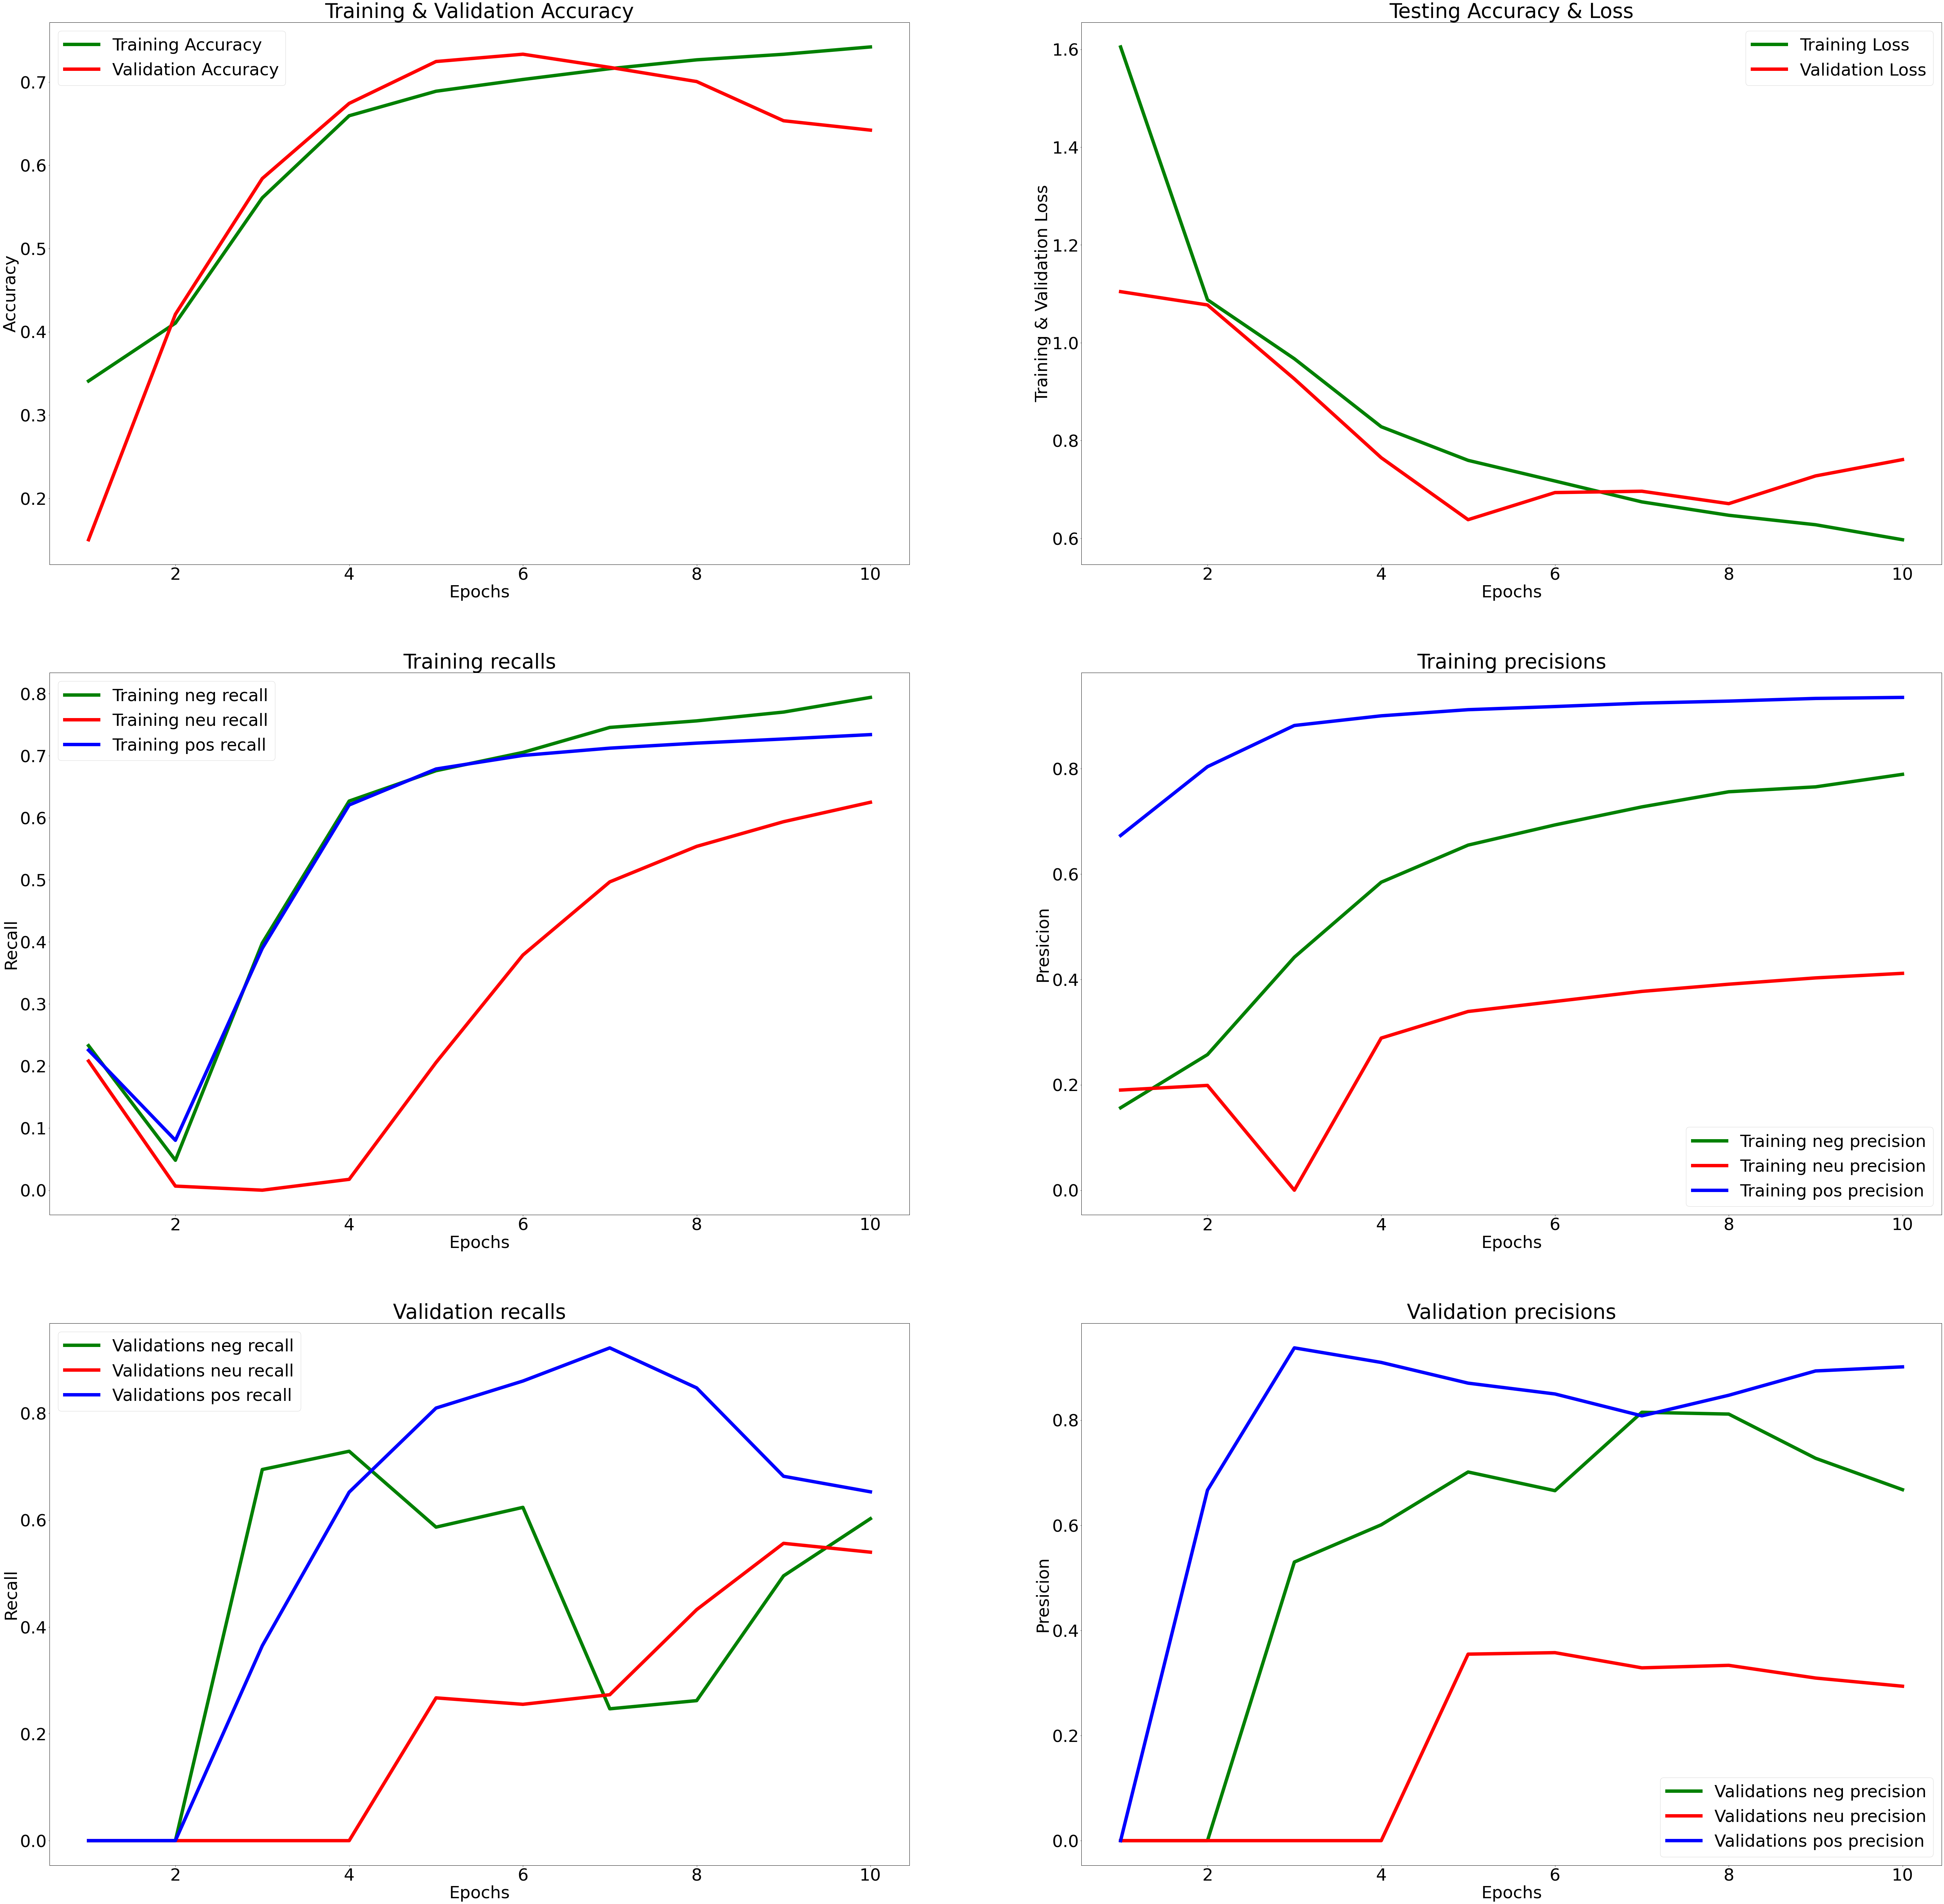

In [121]:
plot_train_info(history.history, 10)

Довольно противно ведут себя precision и recall на валидации. Почему так происходит не совсе понятно.

# Попытка номер два

In [122]:
BATCH_SIZE = 256

output_signature = (tf.TensorSpec(shape = (MAX_LEN), dtype = tf.float64),
                    tf.TensorSpec(shape = (3), dtype = tf.int8))

tf_train, tf_test, tf_val = get_datasets((X_train, y_train), (X_test, y_test), (X_val, y_val),
                                          generators = [BatchGenerator, BatchGenerator, BatchGenerator],
                                          out_sign = output_signature, batch_size = BATCH_SIZE)

Немного усложним сеть за счёт увеличение длины вложений (было 25, стало 30) 

In [124]:
model = Sequential([Embedding(input_dim = (len(vocabulary)), output_dim = (30), mask_zero = True),
                    LSTM(150, activation = 'tanh', name = 'lstm_1', 
                         return_sequences = True, dropout = 0.8),
                    LSTM(100, activation = 'tanh', name = 'lstm_2', 
                         return_sequences = False, dropout = 0.8),
                    BatchNormalization(),
                    Dense(75, name = 'dense_1', activation = 'relu'),
                    BatchNormalization(),
                    Dropout(0.8),
                    Dense(3, name = 'dense_out', activation = 'softmax')], name = 'WithEmbeddings')

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy',
              metrics = METRICS)
model.summary()

Model: "WithEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 30)          6083760   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 150)         108600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               100400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
batch_normalization_5 (Batch (None, 75)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)             

In [125]:
# Так же, на этот раз уменьшать learning rate по экспоненте после 7-ой эпохи, а не 10-ой
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

# Его величество tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\2nd\ep{epoch:02d}_v_l_{val_loss:.2f}.hdf5',
                            save_best_only = False)

history = model.fit(tf_train.repeat(), steps_per_epoch = len(y_train) // BATCH_SIZE,
                    validation_data = tf_val.repeat(), validation_steps = len(y_val) // BATCH_SIZE,
                    epochs = 25,
                    callbacks = CALLBACKS + [tensorboard_callback, model_checkpoint_callback, lr_callback],
                    class_weight = CLASS_WEIGHTS)

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
308/308 [==============================] - 1216s 4s/step - loss: 1.5975 - accuracy: 0.3400 - r_neg: 0.3293 - r_neu: 0.2921 - r_pos: 0.3360 - p_neg: 0.2449 - p_neu: 0.2263 - p_pos: 0.7765 - val_loss: 1.1553 - val_accuracy: 0.1502 - val_r_neg: 0.0000e+00 - val_r_neu: 0.0000e+00 - val_r_pos: 0.0000e+00 - val_p_neg: 0.0000e+00 - val_p_neu: 0.0000e+00 - val_p_pos: 0.0000e+00
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
308/308 [==============================] - 1169s 4s/step - loss: 1.0617 - accuracy: 0.4624 - r_neg: 0.1489 - r_neu: 0.0107 - r_pos: 0.1845 - p_neg: 0.3221 - p_neu: 0.2307 - p_pos: 0.8418 - val_loss: 0.8453 - val_accuracy: 0.6680 - val_r_neg: 0.0023 - val_r_neu: 0.0024 - val_r_pos: 0.9868 - val_p_neg: 1.0000 - val_p_neu: 0.4138 - val_p_pos: 0.6956
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.00100000004749

In [126]:
test_pred = model.predict(X_test)

print(classification_report(one_hot_to_labels(test_pred), one_hot_to_labels(y_test)))

              precision    recall  f1-score   support

         neg       0.55      0.72      0.62      3026
         neu       0.55      0.31      0.40      8655
         pos       0.74      0.88      0.81     14653

    accuracy                           0.68     26334
   macro avg       0.61      0.64      0.61     26334
weighted avg       0.66      0.68      0.65     26334



В некоторых смыслах стало лучше, в некоторых хуже. Дабы не разводить описание изменений на кучу букв, вот, держите:

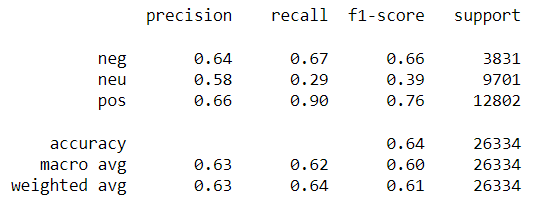

В целом, как по мне, стало хуже, ибо f1-score для 

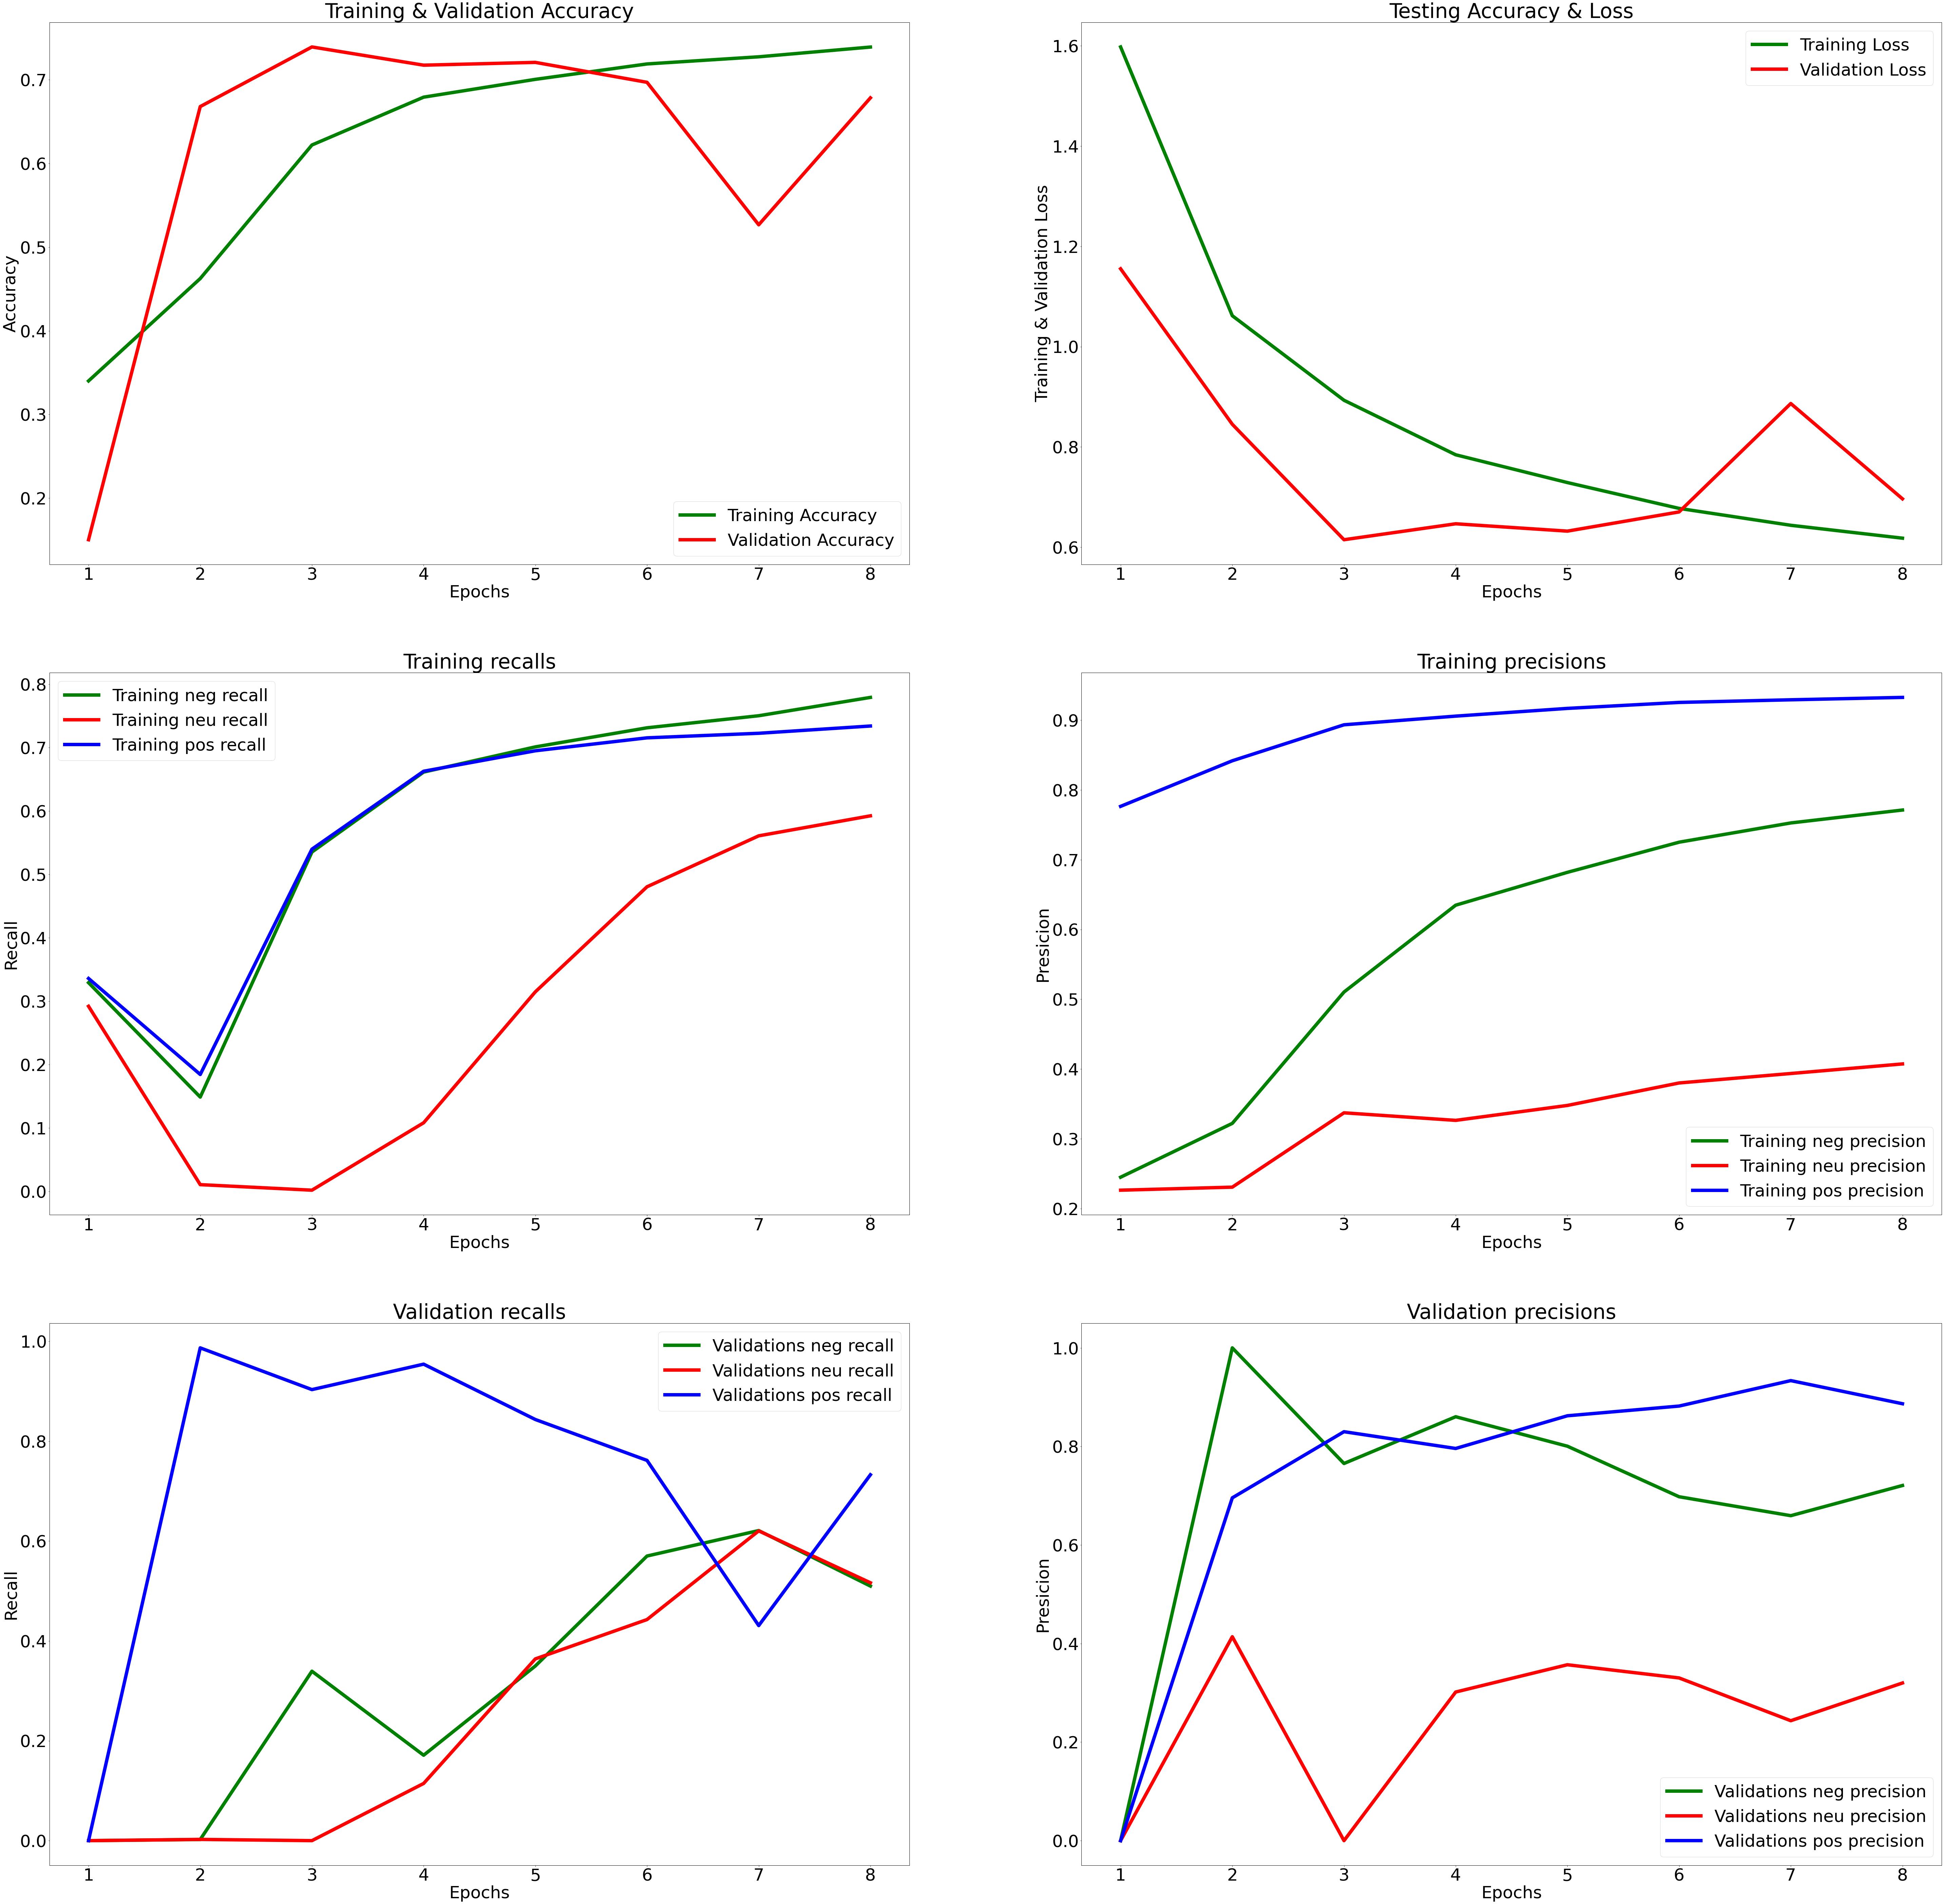

In [128]:
plot_train_info(history.history, 8)

Привлекательно выглядит модель после 7-ой эпохи. Посмотрим поближе

In [18]:
loaded_model = tf.keras.models.load_model(r'saved_models\2nd\ep07_v_l_0.89.hdf5')

test_pred = loaded_model.predict(X_test)

print(classification_report(one_hot_to_labels(test_pred), one_hot_to_labels(y_test)))

              precision    recall  f1-score   support

         neg       0.79      0.74      0.76      4233
         neu       0.76      0.29      0.42     12859
         pos       0.51      0.96      0.67      9242

    accuracy                           0.60     26334
   macro avg       0.69      0.67      0.62     26334
weighted avg       0.68      0.60      0.56     26334



На сей раз всё стало заметно хуже по части положительных отзывов (в смысле precision и, как следствие, f1-score), однако заметно лучше по части негативных отзывов. У нейтральных заметно упал recall, но заметно увеличился precision, что не мудрено: сеть решила, что нейтральных отзывов тут аж почти 13 тысяч, что плохо. Точность в целом упала. Оно тоже не мудрено: положительных отзывов большинство

Теперь предлагаю ещё чуть-чуть усложнить архитектуру (увеличить длину вложений на 5, добавить по 25 нейронов в каждый слой, кроме, разумеется, выходного) и исключить callback, что останавливает обучение, если потеря на валидации не падает пять эпох подряд 

# Сеть под номером три

In [14]:
# К сожалению, только сейчас заметил, что размер батча можно существенно увеличить
BATCH_SIZE = 400

output_signature = (tf.TensorSpec(shape = (MAX_LEN), dtype = tf.float64),
                    tf.TensorSpec(shape = (3), dtype = tf.int8))

tf_train, tf_test, tf_val = get_datasets((X_train, y_train), (X_test, y_test), (X_val, y_val),
                                          generators = [BatchGenerator, BatchGenerator, BatchGenerator],
                                          out_sign = output_signature, batch_size = BATCH_SIZE)

In [15]:
model = Sequential([Embedding(input_dim = (len(vocabulary)), output_dim = (35), mask_zero = True),
                    LSTM(175, activation = 'tanh', name = 'lstm_1', 
                         return_sequences = True, dropout = 0.8),
                    LSTM(125, activation = 'tanh', name = 'lstm_2', 
                         return_sequences = False, dropout = 0.8),
                    BatchNormalization(),
                    Dense(100, name = 'dense_1', activation = 'relu'),
                    BatchNormalization(),
                    Dropout(0.8),
                    Dense(3, name = 'dense_out', activation = 'softmax')], name = 'WithEmbeddings')

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy',
              metrics = METRICS)
model.summary()

Model: "WithEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 35)          7097720   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 175)         147700    
_________________________________________________________________
lstm_2 (LSTM)                (None, 125)               150500    
_________________________________________________________________
batch_normalization (BatchNo (None, 125)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)            

In [16]:
# Всё ещё уменьшать learning rate по экспоненте после 7-ой эпохи, а не 10-ой
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

# Его величество tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/3rd', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\3rd\ep{epoch:02d}_v_l_{val_loss:.2f}.hdf5',
                            save_best_only = False)

history = model.fit(tf_train.repeat(), steps_per_epoch = len(y_train) // BATCH_SIZE,
                    validation_data = tf_val.repeat(), validation_steps = len(y_val) // BATCH_SIZE,
                    epochs = 25,
                    callbacks = [tensorboard_callback, model_checkpoint_callback, lr_callback],
                    class_weight = CLASS_WEIGHTS)

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
197/197 [==============================] - 750s 4s/step - loss: 1.6688 - accuracy: 0.3280 - r_neg: 0.2422 - r_neu: 0.2237 - r_pos: 0.2066 - p_neg: 0.1539 - p_neu: 0.1902 - p_pos: 0.6652 - val_loss: 0.9139 - val_accuracy: 0.6618 - val_r_neg: 0.0000e+00 - val_r_neu: 0.0000e+00 - val_r_pos: 0.9962 - val_p_neg: 0.0000e+00 - val_p_neu: 0.0000e+00 - val_p_pos: 0.6628
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
197/197 [==============================] - 738s 4s/step - loss: 1.1216 - accuracy: 0.4106 - r_neg: 0.0666 - r_neu: 0.0162 - r_pos: 0.0855 - p_neg: 0.2617 - p_neu: 0.2221 - p_pos: 0.8069 - val_loss: 0.8055 - val_accuracy: 0.6623 - val_r_neg: 0.0000e+00 - val_r_neu: 0.0055 - val_r_pos: 0.8713 - val_p_neg: 0.0000e+00 - val_p_neu: 0.4426 - val_p_pos: 0.7721
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974

Epoch 19/25

Epoch 00019: LearningRateScheduler setting learning rate to tf.Tensor(0.00033287084, shape=(), dtype=float32).
197/197 [==============================] - 745s 4s/step - loss: 0.4036 - accuracy: 0.8154 - r_neg: 0.8971 - r_neu: 0.8086 - r_pos: 0.7920 - p_neg: 0.8873 - p_neu: 0.5177 - p_pos: 0.9617 - val_loss: 0.9444 - val_accuracy: 0.6815 - val_r_neg: 0.5799 - val_r_neu: 0.4408 - val_r_pos: 0.7682 - val_p_neg: 0.6482 - val_p_neu: 0.3092 - val_p_pos: 0.8611
Epoch 20/25

Epoch 00020: LearningRateScheduler setting learning rate to tf.Tensor(0.00030119397, shape=(), dtype=float32).
197/197 [==============================] - 741s 4s/step - loss: 0.3956 - accuracy: 0.8203 - r_neg: 0.8994 - r_neu: 0.8164 - r_pos: 0.7979 - p_neg: 0.8910 - p_neu: 0.5258 - p_pos: 0.9633 - val_loss: 0.9454 - val_accuracy: 0.7152 - val_r_neg: 0.4285 - val_r_neu: 0.3700 - val_r_pos: 0.8737 - val_p_neg: 0.7342 - val_p_neu: 0.3361 - val_p_pos: 0.8264
Epoch 21/25

Epoch 00021: LearningRateScheduler setting 

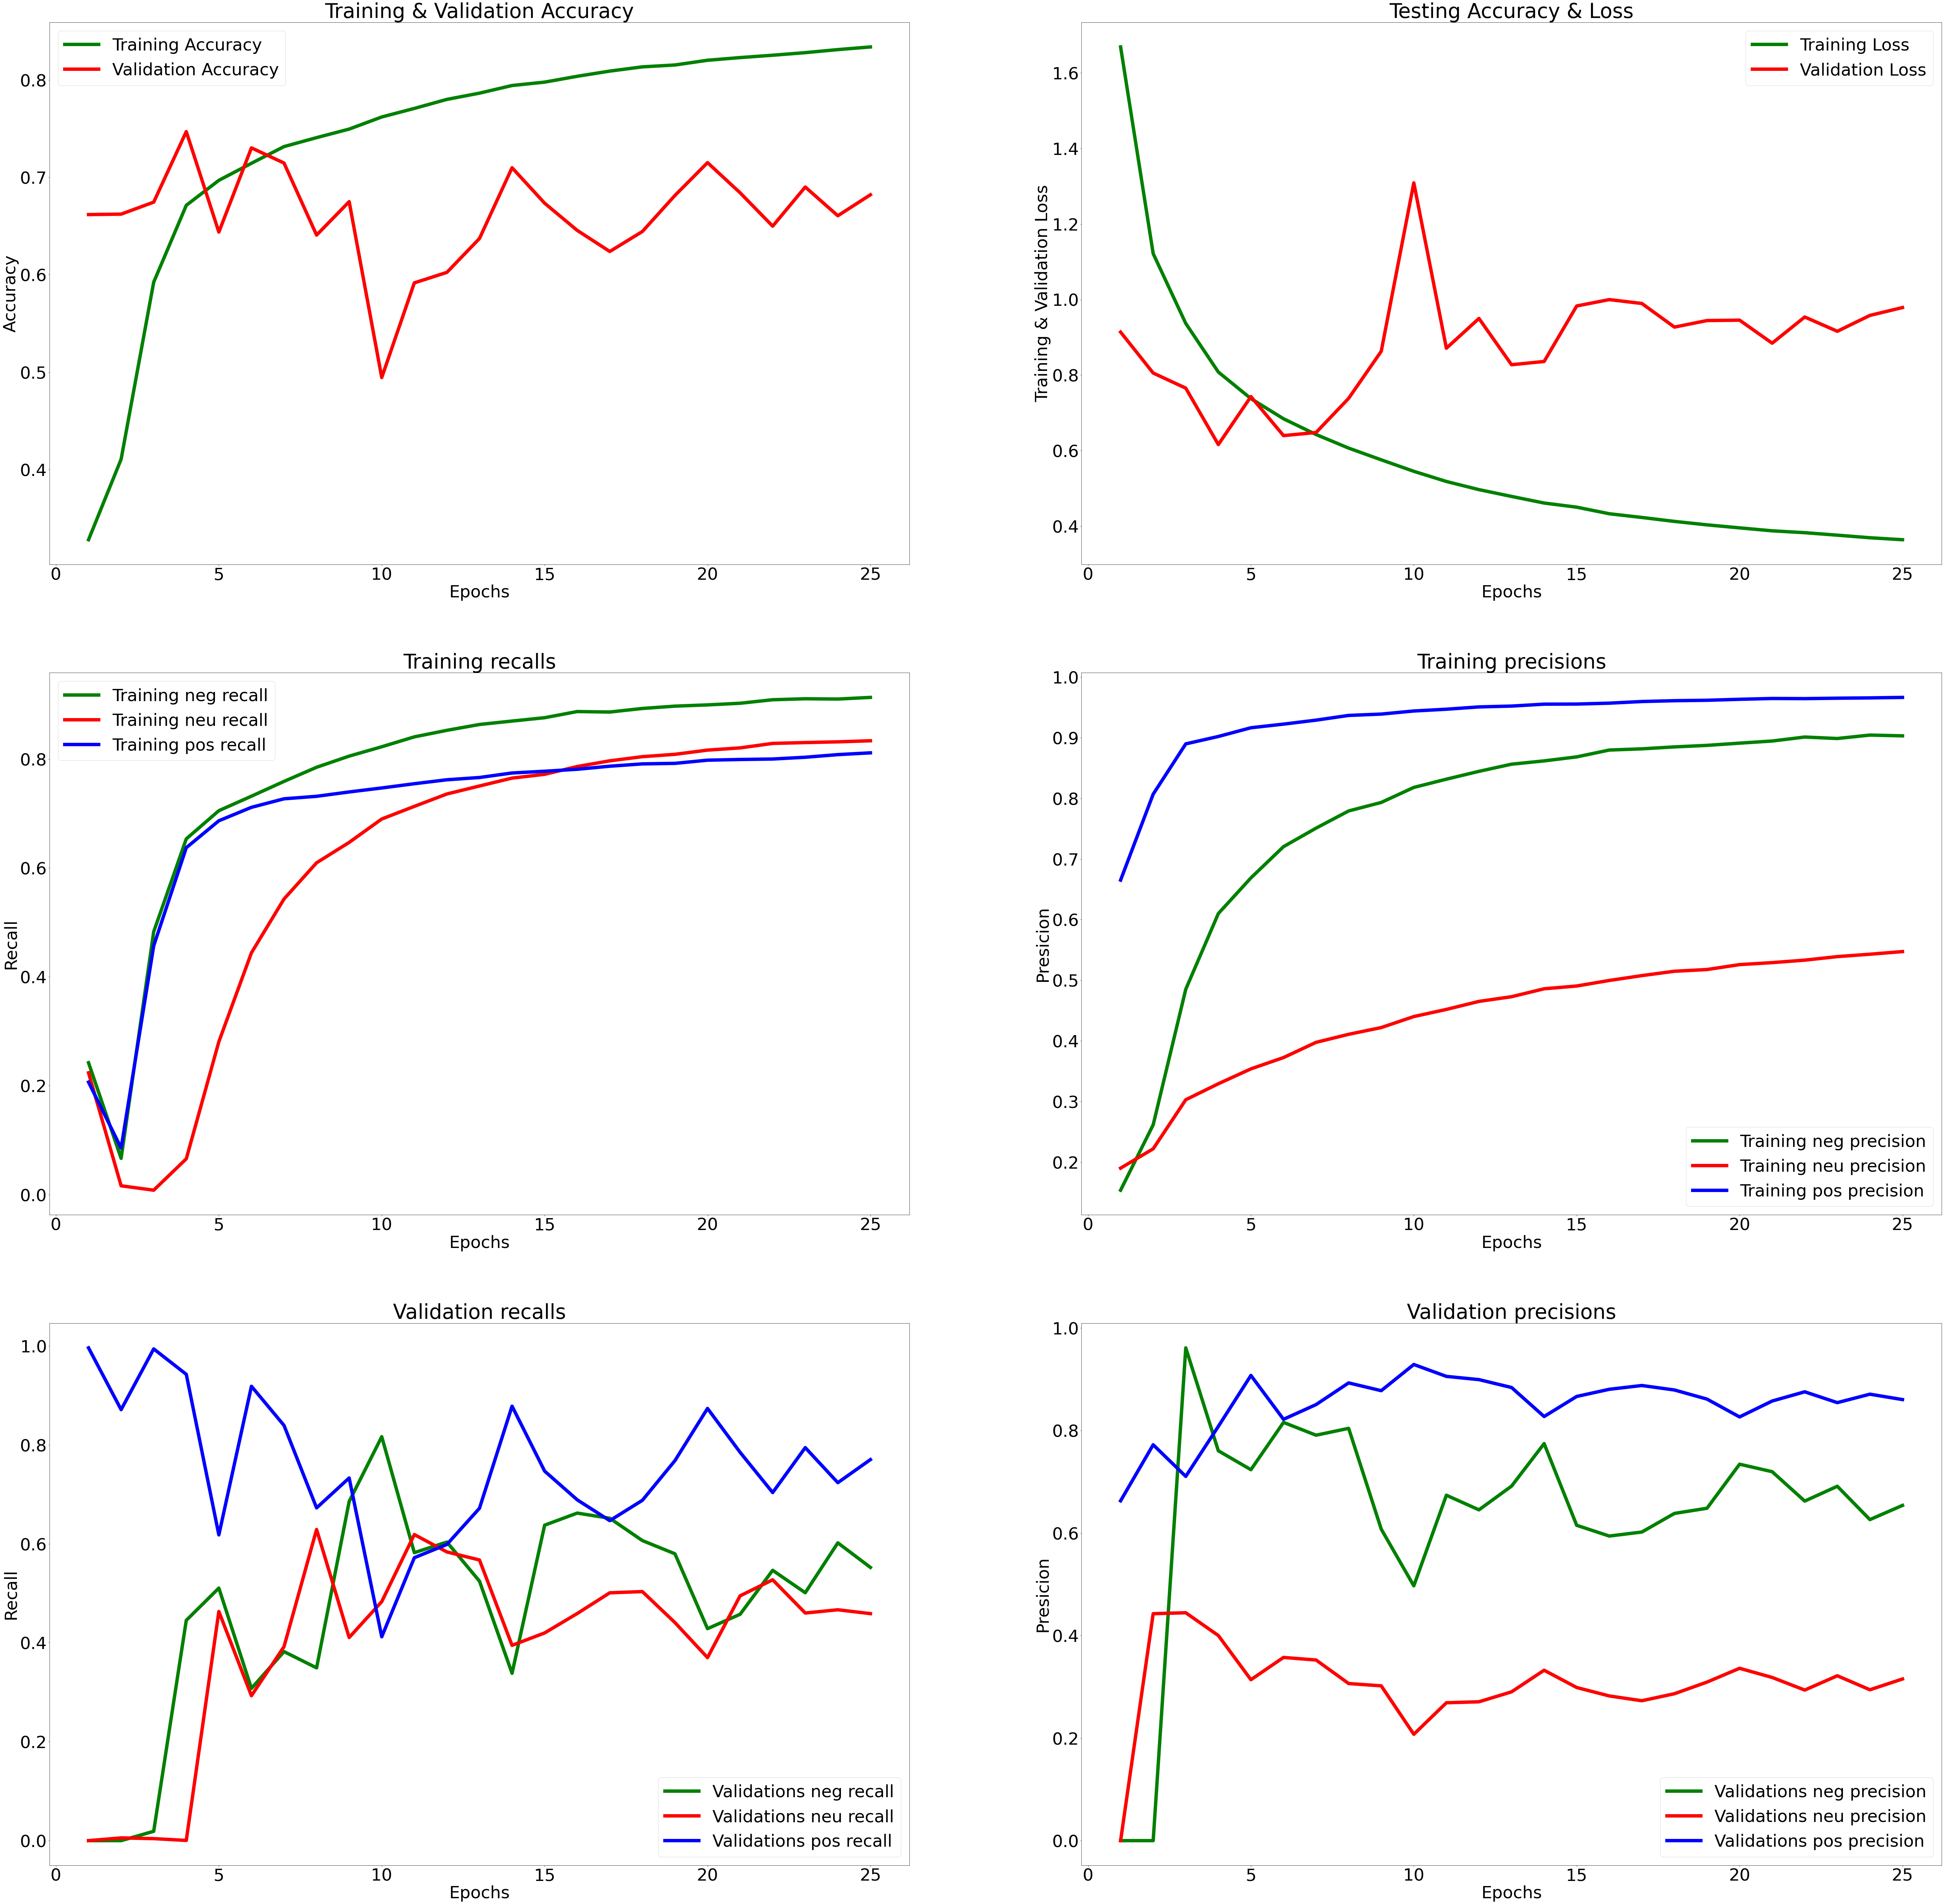

In [18]:
plot_train_info(history.history, 25)

Пожалуй, лучшая из этих моделей обитает на 17-ой эпохе:

In [17]:
loaded_model = tf.keras.models.load_model(r'saved_models\3rd\ep17_v_l_0.99.hdf5')

test_pred = loaded_model.predict(X_test)

print(classification_report(one_hot_to_labels(test_pred), one_hot_to_labels(y_test)))

              precision    recall  f1-score   support

         neg       0.84      0.77      0.81      4313
         neu       0.75      0.44      0.55      8496
         pos       0.74      0.95      0.83     13525

    accuracy                           0.76     26334
   macro avg       0.78      0.72      0.73     26334
weighted avg       0.76      0.76      0.74     26334



Есть у меня обоснованное предположение, состоящее в том, что нейтральный отзывы заметно так портят мне жизнь. Судь об этом можно по precision нейтрального класса, который даже на обучающей выборке не достигает и 60-ти процентов. Оно и логично, ведь нейтральные отзывы устроены наиболее разнообразно: весь отзыв может быть написан в нейтральном ключе, часть отзыва может быть резко негативной, часть резко положительной. Да и вообще, составитель датасета не поясняет что имеется в виду под каждым классом отзывов. Вероятно, имело место простое разбиение по кол-ву баллов из десяти, оставленных автором. Из серии: если оценка от 1 до 3, то отзыв негативный, если от 4 до 6, то нейтральный и если от 7 до 10, то положительный. Надо на этот счёт что-то выдумывать. Вот некоторые варианты того, что было бы неплохо испробоватб:
1. Увеличить вес нейтральных отзывов и верить в лучшее. 
2. Пошаманить с оптимизаторами, ибо кажется, что точность на валидации вечно прыгает вокруг некоего оптимума. 
3. Разбить выборку на тренировочную, валидационную и тестовую части в соотношении 70/20/10, дабы на обучении захватить побольше разнообразных примеров. 
4.В конце концов, использовать другие архитектуры. Да хоть свёрточные 

В общем, количество вариантов растёт по экспоненте в зависимости от времени, потраченного на сей датасет. С одной стороны, царствие небесное моей видеокарте, с другой, так и приобретается опыт

Хочется заметить, что я, по видимому, не зря изначально не захотел пробовать классические методы навроде Bag of words + что-то линейное, потому что хоть [этому товарищу](https://www.kaggle.com/code/mihxsp/reviews-classification-with-tf-idf-and-svm) (который использовал связку tf-idf + SVM) моя сеть хоть и проигрывать в 2 процентных пункта в плане точности и по части положительных отзывов у меня всё несколько хуже, по части негативных и нейтральных, эта сеть показывает себя значительно лучше во всех смыслах. Вот, для наглядности (и тех, кому лень ходить по ссылкам), отчет о классификации этого парня:
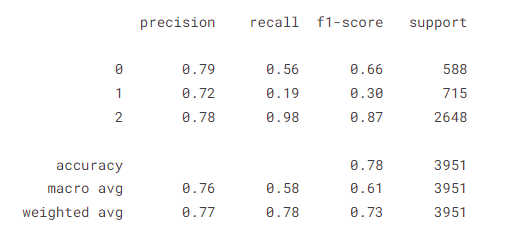

Что ж, в данный момент хочется убедиться, что дело действительно в нейтральных отзывах и посмотреть справятся ли сети схожих архитектур с классификацией на два класса (положительный и негативный). Это вы можете узнать в блокноте Without neutrals. Как только какой-то из вышеуказанных вариантов улучшения ситуации сработает, я к вам вернусь :)